In [1]:
import plotly.graph_objects as go
import sys
import os

%load_ext Cython

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt

import numba
print(numba.__version__)

from scipy.stats import bernoulli

import itertools

from joblib import Parallel, delayed


0.44.1


In [5]:
adjMat = np.zeros((36,36))

adjMat1 = np.zeros((36,36))

In [6]:
adjMat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [2]:
def create_adj_mat(cells_type):
    #cells type = 1 is the play your neighbour type -- i.e the cells are 
    
    adjMat = np.zeros((36,36))

    
    if cells_type == 1:
        
        #pot i to pot i+1 matches
        for i in range(3):
            for j in range(9):
                adjMat[i*9+j, ((i+1)*9+j)] = 1
                adjMat[i*9+j, ((i+1)*9+((j+1)%9))] = 1

        #pot i to pot i+2 matches
        for i in range(2):
            for j in range(9):
                adjMat[i*9+j, ((i+2)*9+j)] = 1
                adjMat[i*9+j, ((i+2)*9+((j+1)%9))] = 1

        #pot i to pot i+3 matches
        for i in range(1):
            for j in range(9):
                adjMat[i*9+j, ((i+3)*9+j)%36] = 1
                adjMat[i*9+j, ((i+3)*9+((j+1)%9))%36] = 1
        
        #cross pot matches
        for i in range(4):
            for j in range(9):
                adjMat[i*9+j, i*9+((j+1)%9)] = 1
                
    elif cells_type == 0:
        for i in range(3):
            for j in range(9):
                adjMat[i*9+j, ((i+1)*9+j)] = 1
                adjMat[i*9+j, ((i+1)*9+(j+1)%9)] = 1
        for j in range(9):
            adjMat[3*9+j, (((3+1)*9+j+2)%36)%9] = 1
            adjMat[3*9+j, (((3+1)*9+j+3)%36)%9] = 1
            #print(3*9+j, (((3+1)*9+j+2)%36)%9, (((3+1)*9+j+3)%36)%9)

        for i in range(2):
            for j in range(9):
                adjMat[i*9+j, ((i+2)*9+j)] = 1
                adjMat[i*9+j, ((i+2)*9+((j+1)%9))] = 1

        for i in range(4):
            for j in range(9):
                adjMat[i*9+j, i*9+((j+1)%9)] = 1
                
    
    #cells random, with gareths constraint            
    elif cells_type == 3:
        for games_cells in list_games:
            i = games_cells[0]
            j = games_cells[1]
            matches = np.random.permutation(np.arange(3))
            for k in range(3):
                adjMat[i*3 + k, j*3 + matches[k]] = 1
            
#     #singles random
#     elif cells_type == 4:
#         #pot i to pot i+1 matches
#         for i in range(3):
#             matches = produce_random_matching()
#             for j in range(9):
#                 adjMat[i*9+j, ((i+1)*9+matches[j,1])] = 1
#                 adjMat[i*9+j, ((i+1)*9+((j+1)%9))] = 1

#         #pot i to pot i+2 matches
#         for i in range(2):
#             for j in range(9):
#                 adjMat[i*9+j, ((i+2)*9+j)] = 1
#                 adjMat[i*9+j, ((i+2)*9+((j+1)%9))] = 1

#         #pot i to pot i+3 matches
#         for i in range(1):
#             for j in range(9):
#                 adjMat[i*9+j, ((i+3)*9+j)%36] = 1
#                 adjMat[i*9+j, ((i+3)*9+((j+1)%9))%36] = 1
        
#         #cross pot matches
#         for i in range(4):
#             for j in range(9):
#                 adjMat[i*9+j, i*9+((j+1)%9)] = 1
                
    #completely random
    elif cells_type == 5:
        for i in range(4):
            for j in range(i,4):
                #print(i,j)
                if i==j:
                    game1 = prod_rand_matching_two_same()
                    for k in range(9):
                        adjMat[9*i + k, 9*i + game1[k]] = 1
                        #print("done")
                else: 
                    game1, game2 = prod_rand_matching_two()
                    for k in range(9):
                        adjMat[9*i + k,9*j + game1[k]] = 1
                        adjMat[9*i + k, 9*j + game2[k]] = 1
                                    
    return(adjMat)


In [3]:
def prod_rand_matching():
    mat = np.zeros((36,36))
    for i in range(4):
        for j in range(i,4):
            #print(i,j)
            if i==j:
                game1 = prod_rand_matching_two_same()
                for k in range(9):
                    mat[9*i + k, 9*i + game1[k]] = 1
                    #print("done")
            else: 
                game1, game2 = prod_rand_matching_two()
                for k in range(9):
                    mat[9*i + k,9*j + game1[k]] = 1
                    mat[9*i + k, 9*j + game2[k]] = 1
    return(mat)

In [10]:
def rej_sampler_matrix(N=10, type_topology=3, to_shuffle = np.full((4, 9), True), pots_arr= pots_copy):
    count_meta = np.zeros(N)
    pots_arr_list = []
    #print(pots_arr[0,:,:])
    #np.random.shuffle(pots_arr[0,to_shuffle[0,:],:])
    #print(pots_arr[0,:,:])
    for n in range(N):
        count = 0
        boo = True
        while(boo):
            adj_mat = create_adj_mat(type_topology)
            adjMatT = np.transpose(adj_mat)
            adj_mat = adj_mat + adjMatT
            for i in range(4):
                undrawn = pots_arr[i,to_shuffle[i,:],:]
                np.random.shuffle(undrawn)
                pots_arr[i,to_shuffle[i,:],:] = undrawn
            #print(pots_arr[0,:,:])
            pots_countries = pots_arr[:,:,1]
            pots_countries = pots_countries.flatten()
            
            
#             # Check if any element is equal and adj_mat condition is met
#             mask = (pots_countries[:, :, None] == pots_countries[:, None, :]) & adj_mat
#             if np.any(mask):
#                 boo = True
#             else:
#                 boo = False
            
#             if np.any(mask*adj_mat):
#                 boo = True
#                 #break
#             #else: boo = False
            boo = False
            for i in range(36):
                for j in range(i,36):
                    if adj_mat[i,j]==1 and pots_countries[i] == pots_countries[j]:
                        boo = True
                        #print(m, r)
                        break
                if boo:
                    break
            count+=1
            #if count%100 == 0:
            #    print(count)
        if n%10 == 0:
            print(n)
        count_meta[n] = count
        
        pots_arr_list.append(np.copy(pots_arr))
    #print("doin")
    return(count_meta, pots_arr_list)


def rej_sampler_matrix_print(N, type_topology):
    rng = np.random.default_rng()
    count_meta = np.zeros(N)
    pots_arr = np.array(pots)
    for n in range(N):
        count = 0
        boo = True
        while(boo):
            adj_mat = create_adj_mat(type_topology)
            adjMatT = np.transpose(adj_mat)
            adj_mat = adj_mat + adjMatT
            for i in range(4):
                np.random.shuffle(pots_arr[i,:,:])
            pots_countries = pots_arr[:,:,1]
            pots_countries = pots_countries.flatten()
            # Check if any element is equal and adj_mat condition is met
#             mask = (pots_countries[:, None] == pots_countries) & adj_mat.astype(bool)
#             if np.any(mask):
#                 boo = True
#             else:
#                 boo = False
            
#             if np.any(mask*adj_mat):
#                 boo = True
#                 #break
                #else: boo = False
            boo = False
            for i in range(36):
                for j in range(i,36):
                    if adj_mat[i,j]==1 and pots_countries[i] == pots_countries[j]:
                        boo = True
                        #print(m, r)
                        break
                if boo:
                    break
            count+=1
        #if n%10 == 0:
            #print(n)
        
        for i in range(36):
            for j in range(i,36):
                if adj_mat[i,j]==1:
                    print(pots_arr[:,:,0].flatten()[i], "vs", pots_arr[:,:,0].flatten()[j])
                    #print(m, r)
        count_meta[n] = count
    return(count_meta)

def rej_sampler_matrix_cells(N=10):
    count_meta = np.zeros(N)
    pots_arr = np.array(pots)
    for n in range(N):
        count = 0
        boo = True
        while(boo):
            for i in range(4):
                np.random.shuffle(pots_arr[i,:,:])
            pots_countries = pots_arr[:,:,1]
            pots_countries = pots_countries.flatten()
            mults = np.zeros(48)
            for k, game_cell in enumerate(list_games):
                i = game_cell[0]
                j = game_cell[1]
                permutations_j = itertools.permutations(pots_countries[3*j:3*(j+1)])
                celli = pots_countries[3*i:3*(i+1)]
                #print(celli, permutations_j)
                poss = 6
                for perm in permutations_j:
                    #print(perm)
                    if(sum([celli[m] == perm[m] for m in range(3)])>0):
                        poss = poss - 1
                mults[k] = poss
                
            #print(np.prod(mults/6))
            boo = bernoulli.rvs(1-np.prod(mults/6), size = 1)
            count+=1
        if n%10 == 0:
            print(n)
        count_meta[n] = count
    return(count_meta)


In [11]:
def rej_sampler_matrix_single(type_topology = 3, to_shuffle = np.full((4, 9), True), pots_arr= np.array(np.copy(pots))):
    #print(pots_arr[0,:,:])
    #np.random.shuffle(pots_arr[0,to_shuffle[0,:],:])
    #print(pots_arr[0,:,:])
    boo = True
    count = 0
    while(boo):
        adj_mat = create_adj_mat(type_topology)
        adjMatT = np.transpose(adj_mat)
        adj_mat = adj_mat + adjMatT
        for i in range(4):
            undrawn = pots_arr[i,to_shuffle[i,:],:]
            np.random.shuffle(undrawn)
            pots_arr[i,to_shuffle[i,:],:] = undrawn
        #print(pots_arr[0,:,:])
        pots_countries = pots_arr[:,:,1]
        pots_countries = pots_countries.flatten()


        boo = False
        for i in range(36):
            for j in range(i,36):
                if adj_mat[i,j]==1 and pots_countries[i] == pots_countries[j]:
                    boo = True
                    #print(m, r)
                    break
            if boo:
                break
        count = count + 1
    
    return((count,pots_arr))

In [19]:
pots_copy = np.array(np.copy(pots))
#num_processes = multiprocessing.cpu_count()  # Get the number of CPU cores


results = Parallel(n_jobs=6)(delayed(rej_sampler_matrix_single)() for _ in range(100))


In [239]:
results

[array([], dtype=float64),
 array([3291.]),
 array([3291.,  578.]),
 array([3291.,  578.,  396.]),
 array([3291.,  578.,  396.,  600.]),
 array([3291.,  578.,  396.,  600., 1481.]),
 array([3291.,  578.,  396.,  600., 1481., 4305.]),
 array([3291.,  578.,  396.,  600., 1481., 4305.,  566.])]

In [546]:
import cProfile

cProfile.run('rej_sampler_matrix_print(10, 3)')

         9582147 function calls in 14.533 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    36023    4.315    0.000   12.064    0.000 127171709.py:1(create_adj_mat)
        1    1.287    1.287   14.533   14.533 2177523659.py:45(rej_sampler_matrix_print)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(concatenate)
   144092    0.069    0.000    0.146    0.000 <__array_function__ internals>:2(empty_like)
  1729104    0.756    0.000    1.633    0.000 <__array_function__ internals>:2(may_share_memory)
    36023    0.023    0.000    0.110    0.000 <__array_function__ internals>:2(transpose)
        1    0.000    0.000   14.533   14.533 <string>:1(<module>)
        2    0.000    0.000    0.000    0.000 _ufunc_config.py:131(geterr)
        2    0.000    0.000    0.000    0.000 _ufunc_config.py:32(seterr)
        1    0.000    0.000    0.000    0.000 _ufunc_config.py:429(__enter__)
        1    0.00

In [107]:

sample, sample1 = rej_sampler_matrix(100, 3)
print(sample1)

0
10
20
30
40
50
60
70
80
90
[array([[['Spain1', 'Spain'],
        ['England2', 'England'],
        ['Italy1', 'Italy'],
        ['Spain3', 'Spain'],
        ['England3', 'England'],
        ['Germany1', 'Germany'],
        ['Spain2', 'Spain'],
        ['France1', 'France'],
        ['England1', 'England']],

       [['Italy2', 'Italy'],
        ['France2', 'France'],
        ['Germany2', 'Germany'],
        ['Germany4', 'Germany'],
        ['Spain4', 'Spain'],
        ['Germany3', 'Germany'],
        ['Portugal1', 'Portugal'],
        ['Netherlands1', 'Netherlands'],
        ['England4', 'England']],

       [['Hungary1', 'Hungary'],
        ['France3', 'France'],
        ['Switzerland1', 'Switzerland'],
        ['Germany5', 'Germany'],
        ['Belgium1', 'Belgium'],
        ['Denmark1', 'Denmark'],
        ['Portugal2', 'Portugal'],
        ['Belgium2', 'Belgium'],
        ['Norway1', 'Norway']],

       [['Ukraine1', 'Ukraine'],
        ['Sweden1', 'Sweden'],
        ['Scotland1',

In [116]:
[sample1[i][0][1:3] for i in range(100)]

[array([['England2', 'England'],
        ['Italy1', 'Italy']], dtype='<U12'),
 array([['Spain2', 'Spain'],
        ['England2', 'England']], dtype='<U12'),
 array([['Spain2', 'Spain'],
        ['Italy1', 'Italy']], dtype='<U12'),
 array([['Germany1', 'Germany'],
        ['Spain2', 'Spain']], dtype='<U12'),
 array([['Italy1', 'Italy'],
        ['England3', 'England']], dtype='<U12'),
 array([['England3', 'England'],
        ['Germany1', 'Germany']], dtype='<U12'),
 array([['England2', 'England'],
        ['England3', 'England']], dtype='<U12'),
 array([['England1', 'England'],
        ['Spain2', 'Spain']], dtype='<U12'),
 array([['England2', 'England'],
        ['Italy1', 'Italy']], dtype='<U12'),
 array([['Germany1', 'Germany'],
        ['England2', 'England']], dtype='<U12'),
 array([['England3', 'England'],
        ['France1', 'France']], dtype='<U12'),
 array([['Spain2', 'Spain'],
        ['England3', 'England']], dtype='<U12'),
 array([['England1', 'England'],
        ['England3', 

In [551]:

rej_sampler_matrix_print(1, 5)


France1 vs England1
France1 vs Spain2
France1 vs Germany3
France1 vs Germany2
France1 vs Norway1
France1 vs Germany5
France1 vs Greece1
France1 vs Croatia1
England2 vs Spain3
England2 vs Germany1
England2 vs Spain4
England2 vs Germany4
England2 vs France3
England2 vs Switzerland1
England2 vs Turkey1
England2 vs Greece1
England1 vs Spain2
England1 vs Spain4
England1 vs Netherlands1
England1 vs Hungary1
England1 vs Portugal2
England1 vs Ukraine1
England1 vs Czech1
Spain3 vs Germany1
Spain3 vs Italy2
Spain3 vs Portugal1
Spain3 vs Denmark1
Spain3 vs Germany5
Spain3 vs Ukraine1
Spain3 vs Scotland1
Italy1 vs England3
Italy1 vs Spain1
Italy1 vs Germany2
Italy1 vs England4
Italy1 vs France3
Italy1 vs Norway1
Italy1 vs Finland1
Italy1 vs Austria1
England3 vs Spain1
England3 vs Portugal1
England3 vs France2
England3 vs Belgium1
England3 vs Switzerland1
England3 vs Sweden1
England3 vs Scotland1
Spain1 vs Netherlands1
Spain1 vs Germany4
Spain1 vs Belgium2
Spain1 vs Portugal2
Spain1 vs Finland1
Spa

array([58.])

In [201]:
to_shuffle = np.full((4, 9), True)
#to_shuffle[0,0] = False
counts_random = rej_sampler_matrix(100,3, to_shuffle)
counts_random

0
10
20
30
40
50
60
70
80
90


(array([ 2309.,  4005.,    19.,  5105.,  3180.,  4177.,  1625.,  2798.,
         2502.,   891.,   261., 10529.,  6608.,   722.,   189.,  9908.,
         6650.,    75.,  1047.,  1037.,  5142.,  1252.,  6037.,  8347.,
          650.,   384.,  7470.,  2304.,   302.,  3400.,  1180.,  2136.,
         6781.,  1674.,   424.,  1132.,  1285.,  6276.,  1481.,  3239.,
        11291.,   752.,  6081.,  1932.,  2631.,  2051.,  3388.,  3844.,
          495.,   795.,  1039.,   281.,  5624.,  2361.,  3814.,  6368.,
         5228.,    30.,  1468.,  4019.,   136.,  6595.,  2504.,   158.,
         6902.,  1975.,  1421.,  5959.,   491.,  5543.,  2231.,  1758.,
         2880.,  8814.,   100.,   907.,  1353.,  4495.,  1090.,  2552.,
          133.,   484.,  4115.,  1881.,  3268.,   345.,  4410.,   292.,
          736.,   428.,  1301.,  5584.,   162.,   495.,  3991.,   751.,
        12182.,   579.,   163.,  4952.]),
 [array([[['Spain2', 'Spain'],
          ['England3', 'England'],
          ['England1', 'Engl

In [139]:
[counts_random[1][i][0][1][0] for i in range(30)]

['Germany1',
 'England1',
 'Spain1',
 'Spain2',
 'England1',
 'Germany1',
 'Spain3',
 'England2',
 'England1',
 'England2',
 'England3',
 'Italy1',
 'Spain1',
 'France1',
 'Germany1',
 'England1',
 'England1',
 'Spain1',
 'England1',
 'England3',
 'Italy1',
 'Spain3',
 'France1',
 'Spain1',
 'France1',
 'Spain2',
 'Germany1',
 'England2',
 'England3',
 'Spain1']

In [158]:
pots_new = np.array(np.copy(pots))
random_first = np.random.randint(9)
to_shuffle = np.full((4, 9), True)
to_shuffle[0,0] = False
reps = 10
potnum = 0
pots_new[potnum,(0,random_first)] = pots_new[potnum,(random_first,0)]
for j in range(1,9):
    draws, cells_draw = rej_sampler_matrix(reps, 3, to_shuffle, pots_new)
    unique, counts = np.unique([cells_draw[i][potnum][j][0] for i in range(reps)], return_counts=True)
    to_shuffle[potnum,j] = False
    
    probs = counts/reps
    team_drawn = np.random.choice(unique, p=probs)
    
    #another way
    #idx = np.random.randint(reps)
    #team_drawn = cells_draw[idx]
    
    idx = int(np.where(pots_new[potnum,:,0] == team_drawn)[0])
    print(idx)
    pots_new[potnum, (j, idx)] = pots_new[potnum, (idx, j)]
    print(pots_new[potnum, 0:(j+1)])

print([(counts[i], unique[i]) for i in range(len(counts))])

0
8
[['England1' 'England']
 ['Spain1' 'Spain']]
0
3
[['England1' 'England']
 ['Spain1' 'Spain']
 ['Italy1' 'Italy']]
0
4
[['England1' 'England']
 ['Spain1' 'Spain']
 ['Italy1' 'Italy']
 ['Germany1' 'Germany']]
0
4
[['England1' 'England']
 ['Spain1' 'Spain']
 ['Italy1' 'Italy']
 ['Germany1' 'Germany']
 ['England3' 'England']]
0
6
[['England1' 'England']
 ['Spain1' 'Spain']
 ['Italy1' 'Italy']
 ['Germany1' 'Germany']
 ['England3' 'England']
 ['Spain3' 'Spain']]
0
7
[['England1' 'England']
 ['Spain1' 'Spain']
 ['Italy1' 'Italy']
 ['Germany1' 'Germany']
 ['England3' 'England']
 ['Spain3' 'Spain']
 ['Spain2' 'Spain']]
0
7
[['England1' 'England']
 ['Spain1' 'Spain']
 ['Italy1' 'Italy']
 ['Germany1' 'Germany']
 ['England3' 'England']
 ['Spain3' 'Spain']
 ['Spain2' 'Spain']
 ['England2' 'England']]
0
8
[['England1' 'England']
 ['Spain1' 'Spain']
 ['Italy1' 'Italy']
 ['Germany1' 'Germany']
 ['England3' 'England']
 ['Spain3' 'Spain']
 ['Spain2' 'Spain']
 ['England2' 'England']
 ['France1' 'Fran

In [153]:
pots_new = np.array(np.copy(pots))
np.where(pots_new=='Spain2')

(array([0]), array([1]), array([0]))

In [159]:
import multiprocessing

# Get the number of CPU cores
num_cores = multiprocessing.cpu_count()

print("Number of CPU cores:", num_cores)

Number of CPU cores: 8


In [22]:
#rej_sampler_matrix_autojit = numba.jit(rej_sampler_matrix)
counts_random = rej_sampler_matrix(3000, 5)
counts_cells = rej_sampler_matrix(3000, 3)
counts_singles = rej_sampler_matrix(3000, 1)
#pots

np.mean(counts_random)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950


1596.988

/home/s1992251/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


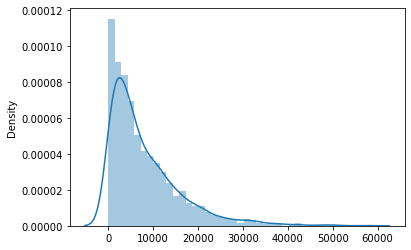

In [479]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(np.concatenate((counts1,counts)))

/home/s1992251/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/s1992251/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/s1992251/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

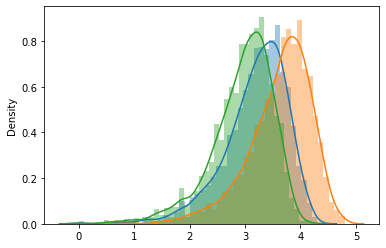

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(np.log10(counts_cells))
sns.distplot(np.log10(counts_singles))
sns.distplot(np.log10(counts_random))

In [27]:
print(np.mean(counts_random))

1596.988


In [448]:
pots_arr = np.array(pots)
for i in range(4):
    np.random.shuffle(pots_arr[i,:,:])

In [449]:
pots_arr

array([[['England2', 'England'],
        ['Spain2', 'Spain'],
        ['Spain1', 'Spain'],
        ['England1', 'England'],
        ['England3', 'England'],
        ['Italy1', 'Italy'],
        ['Spain3', 'Spain'],
        ['France1', 'France'],
        ['Germany1', 'Germany']],

       [['Germany3', 'Germany'],
        ['Germany4', 'Germany'],
        ['Spain4', 'Spain'],
        ['Netherlands1', 'Netherlands'],
        ['Italy2', 'Italy'],
        ['England4', 'England'],
        ['Portugal1', 'Portugal'],
        ['France2', 'France'],
        ['Germany2', 'Germany']],

       [['Denmark1', 'Denmark'],
        ['Norway1', 'Norway'],
        ['Germany5', 'Germany'],
        ['Belgium1', 'Belgium'],
        ['Hungary1', 'Hungary'],
        ['France3', 'France'],
        ['Belgium2', 'Belgium'],
        ['Switzerland1', 'Switzerland'],
        ['Portugal2', 'Portugal']],

       [['Turkey1', 'Turkey'],
        ['Sweden1', 'Sweden'],
        ['Ukraine1', 'Ukraine'],
        ['Finland1',

In [434]:
pots_arr = np.array(pots)
pots_arr = pots_arr.reshape((9,4,2))
#pots_arr
np.random.shuffle(pots_arr)

pots_arr = pots_arr.reshape(4,9,2)
pots_arr

array([[['France1', 'France'],
        ['Portugal1', 'Portugal'],
        ['Netherlands1', 'Netherlands'],
        ['Germany2', 'Germany'],
        ['England2', 'England'],
        ['England3', 'England'],
        ['Germany1', 'Germany'],
        ['Italy1', 'Italy'],
        ['Hungary1', 'Hungary']],

       [['Norway1', 'Norway'],
        ['Denmark1', 'Denmark'],
        ['Austria1', 'Austria'],
        ['Germany3', 'Germany'],
        ['Germany4', 'Germany'],
        ['England4', 'England'],
        ['Italy2', 'Italy'],
        ['France3', 'France'],
        ['Belgium1', 'Belgium']],

       [['Belgium2', 'Belgium'],
        ['Switzerland1', 'Switzerland'],
        ['Scotland1', 'Scotland'],
        ['Ukraine1', 'Ukraine'],
        ['Czech1', 'Czech'],
        ['Greece1', 'Greece'],
        ['Croatia1', 'Croatia'],
        ['Turkey1', 'Turkey'],
        ['Sweden1', 'Sweden']],

       [['Finland1', 'Finland'],
        ['Spain1', 'Spain'],
        ['Spain2', 'Spain'],
        ['Spain3

In [439]:
pots_arr = np.array(pots)
pots_arr = pots_arr.transpose(1,0,2)

np.random.shuffle(pots_arr)
pots_arr

array([[['Spain1', 'Spain'],
        ['Portugal1', 'Portugal'],
        ['Portugal2', 'Portugal'],
        ['Austria1', 'Austria']],

       [['Spain2', 'Spain'],
        ['Netherlands1', 'Netherlands'],
        ['Germany5', 'Germany'],
        ['Croatia1', 'Croatia']],

       [['Spain3', 'Spain'],
        ['Germany2', 'Germany'],
        ['France3', 'France'],
        ['Turkey1', 'Turkey']],

       [['England1', 'England'],
        ['Germany3', 'Germany'],
        ['Belgium1', 'Belgium'],
        ['Sweden1', 'Sweden']],

       [['England2', 'England'],
        ['Germany4', 'Germany'],
        ['Belgium2', 'Belgium'],
        ['Finland1', 'Finland']],

       [['England3', 'England'],
        ['England4', 'England'],
        ['Switzerland1', 'Switzerland'],
        ['Scotland1', 'Scotland']],

       [['Germany1', 'Germany'],
        ['Italy2', 'Italy'],
        ['Hungary1', 'Hungary'],
        ['Ukraine1', 'Ukraine']],

       [['Italy1', 'Italy'],
        ['Spain4', 'Spain'],
    

In [11]:
def prod_rand_matching_two():
        # Generate two random arrays
    array1 = random.sample(range(9), 9)
    array2 = random.sample(range(9), 9)

    # Ensure no numbers are in the same position in each array
    while any(array1[i] == array2[i] for i in range(9)):
        random.shuffle(array2)
    return(array1,array2)

def prod_rand_matching_two_same():
        # Generate two random arrays
    array1 = random.sample(range(9), 9)
    array2 = random.sample(range(9), 9)

    # Ensure no numbers are in the same position in each array
    while any(array1[i] == array2[i] or array1[i]==i for i in range(9)):
        random.shuffle(array1)
    return(array1)

In [278]:
l1,l2 = prod_rand_matching_two()

print(l1,l2)

[4, 0, 8, 5, 6, 2, 7, 3, 1] [5, 3, 7, 2, 1, 0, 4, 8, 6]


In [484]:
adj_mat = create_adj_mat(3)
adjMatT = np.transpose(adj_mat)
adj_mat = adj_mat + adjMatT

adj_mat1 = create_adj_mat(0)
adjMatT1 = np.transpose(adj_mat1)
adj_mat1 = adj_mat1 + adjMatT1

In [12]:
def produce_rand_matching_singles():
    numbs_left = np.arange(0,9)
    matching = np.zeros((9,2))
    for i in range(9):
        #print(np.arange(0,np.size(numbs_left)))
        match = np.random.choice(np.arange(0,np.size(numbs_left)))
        matching[i,:] = np.array([i,numbs_left[match]])
        numbs_left = np.delete(numbs_left, match)
        #print(matching[i,:])
    return matching

In [152]:
produce_rand_matching_singles()

array([[0., 4.],
       [1., 5.],
       [2., 8.],
       [3., 1.],
       [4., 3.],
       [5., 0.],
       [6., 7.],
       [7., 2.],
       [8., 6.]])

In [485]:
#G = nx.from_numpy_array(adj_mat1)
G1 = nx.from_numpy_array(adj_mat)

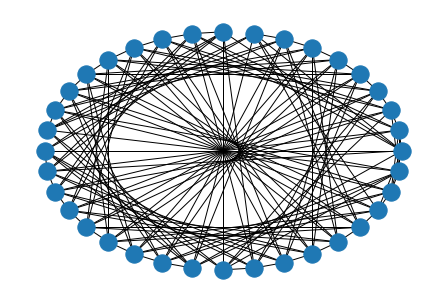

In [81]:
nx.draw_circular(G)

In [487]:
list_games

[[0, 11],
 [1, 3],
 [1, 6],
 [1, 10],
 [2, 4],
 [2, 5],
 [3, 7],
 [3, 11],
 [4, 7],
 [5, 6],
 [5, 9],
 [7, 10],
 [8, 9]]

In [486]:
G1.degree
#G1.adj[0]

DegreeView({0: 1, 1: 1, 2: 1, 3: 3, 4: 3, 5: 3, 6: 2, 7: 2, 8: 2, 9: 3, 10: 3, 11: 3, 12: 2, 13: 2, 14: 2, 15: 3, 16: 3, 17: 3, 18: 2, 19: 2, 20: 2, 21: 3, 22: 3, 23: 3, 24: 1, 25: 1, 26: 1, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 35: 2})

In [123]:
G.adj[0]

AtlasView({1: {'weight': 1.0}, 8: {'weight': 1.0}, 9: {'weight': 1.0}, 10: {'weight': 1.0}, 18: {'weight': 1.0}, 19: {'weight': 1.0}, 33: {'weight': 1.0}, 34: {'weight': 1.0}})

In [129]:
nx.could_be_isomorphic(G,G1)

False

In [71]:
x = (280*280*280*280*6*6*6)
print(f"{x:.2e}")

1.33e+12


# Draw calcs

pot 4 doesn't really make a difference to the draw, in terms of validity, since each team is from a different nation. Hence the denominator for our calculation is going to be $6^{27}$ rather than $6^{48}$ (this is because 21 out of the 48 cell matches contain pot 4. Indeed, for every cell that contains all different teams, every other cell that plays them will have 6 valid options for matches. Since there can be a cell in pot 3 that all have different nationalities, this brings us down to $6^{21}$. If it is possible, there should always be at least $2$ possible match configuration between cells, hence this is $3^{21}$

Pot 1 v Pot 1 is also quite good for this -- there is no overlap between the nationalities across cells. Hence we can take away another 6 off the exponent to get $6^{15}$

We can check the number/proportion of mini 3-leagues there are for the cell method.

The cell method accepts about one in 2700. The singles method accepts about one in 8000. The random method accepts about one in 1600. While these numbers are relatively small, and shouldn't provide too much of a problem obtaining fair samples, for each sample we have to generate an adjacency matrix (36x36) which follows the topology, and this is costly when doing many of them. Could we further restrict the space and pick a certain adjacency matrix? How much randomness do we lose here?


The number of ways to divide each pot into cells is 280 = 9C3 * 6C3 * 3C3/6. Though when doing this singularly the order doesn't matter, it does once you get them together. So in total it would be $280 * 6*280 * 6*280 * 6*280 \simeq 1.33e+12$. i.e each one of these has a number of possible matchups. Need to explore the space quite a lot?

Interesting questions:
irreducibility of mcmc method.

In [5]:
# Define the teams and their countries
teams = [
    ("Spain1", "Spain"), ("Spain2", "Spain"), ("Spain3", "Spain"), ("Spain4", "Spain"),
    ("England1", "England"), ("England2", "England"), ("England3", "England"), ("England4", "England"),
    ("Italy1", "Italy"),  ("Italy2", "Italy"),
    ("Germany1", "Germany"), ("Germany2", "Germany"), ("Germany3", "Germany"), ("Germany4", "Germany"), ("Germany5", "Germany"),
    ("Portugal1", "Portugal"), ("Portugal2", "Portugal"),
    ("Netherlands1", "Netherlands"),
    ("France1", "France"), ("France2", "France"), ("France3", "France"),
    ("Belgium1", "Belgium"), ("Belgium2", "Belgium"),
    ("Switzerland1", "Switzerland"),
    ("Hungary1", "Hungary"),
    ("Norway1", "Norway"),
    ("Denmark1", "Denmark"),
    ("Austria1", "Austria"),
    ("Croatia1", "Croatia"),
    ("Turkey1", "Turkey"),
    ("Sweden1", "Sweden"),
    ("Finland1", "Finland"),
    ("Scotland1", "Scotland"),
    ("Ukraine1", "Ukraine"),
    ("Czech1", "Czech"),
    ("Greece1", "Greece"),
    # Add more teams here
]


# Define pot1 manually
pot1 = [team for team in teams if team[1] == "Spain"][:3] + \
        [team for team in teams if team[1] == "England"][:3]+ \
        [team for team in teams if team[1] == "Germany"][:1] + \
        [team for team in teams if team[1] == "Italy"][:1] + \
        [team for team in teams if team[1] == "France"][:1]

# Remove teams already selected for pot1
teams = [team for team in teams if team not in pot1]

# Define pot2 manually
pot2 = [team for team in teams if team[1] == "Portugal"][:1] + \
        [team for team in teams if team[1] == "Netherlands"][:1] + \
        [team for team in teams if team[1] == "Germany"][:3] + \
        [team for team in teams if team[1] == "England"][:1] + \
        [team for team in teams if team[1] == "Italy"][:1] + \
        [team for team in teams if team[1] == "Spain"][:1] + \
        [team for team in teams if team[1] == "France"][:1]

# Remove teams already selected for pot2
teams = [team for team in teams if team not in pot2]

# Define pot3 manually
pot3 = [team for team in teams if team[1] == "Portugal"][:1] + \
        [team for team in teams if team[1] == "Germany"][:1] + \
        [team for team in teams if team[1] == "France"][:1] + \
        [team for team in teams if team[1] == "Belgium"][:2] + \
        [team for team in teams if team[1] == "Switzerland"][:1] + \
        [team for team in teams if team[1] == "Hungary"][:1] + \
        [team for team in teams if team[1] == "Norway"][:1] + \
        [team for team in teams if team[1] == "Denmark"][:1]

# Remove teams already selected for pot3
teams = [team for team in teams if team not in pot3]

# Define pot4 manually
pot4 = teams

# Combine pots into a list
pots = [pot1, pot2, pot3, pot4]

In [415]:
pots

[[('Spain1', 'Spain'),
  ('Spain2', 'Spain'),
  ('Spain3', 'Spain'),
  ('England1', 'England'),
  ('England2', 'England'),
  ('England3', 'England'),
  ('Germany1', 'Germany'),
  ('Italy1', 'Italy'),
  ('France1', 'France')],
 [('Portugal1', 'Portugal'),
  ('Netherlands1', 'Netherlands'),
  ('Germany2', 'Germany'),
  ('Germany3', 'Germany'),
  ('Germany4', 'Germany'),
  ('England4', 'England'),
  ('Italy2', 'Italy'),
  ('Spain4', 'Spain'),
  ('France2', 'France')],
 [('Portugal2', 'Portugal'),
  ('Germany5', 'Germany'),
  ('France3', 'France'),
  ('Belgium1', 'Belgium'),
  ('Belgium2', 'Belgium'),
  ('Switzerland1', 'Switzerland'),
  ('Hungary1', 'Hungary'),
  ('Norway1', 'Norway'),
  ('Denmark1', 'Denmark')],
 [('Austria1', 'Austria'),
  ('Croatia1', 'Croatia'),
  ('Turkey1', 'Turkey'),
  ('Sweden1', 'Sweden'),
  ('Finland1', 'Finland'),
  ('Scotland1', 'Scotland'),
  ('Ukraine1', 'Ukraine'),
  ('Czech1', 'Czech'),
  ('Greece1', 'Greece')]]

In [13]:
# Function to divide a pot into cells
def divide_pot_into_cells(pot):
    random.shuffle(pot)
    cells = [pot[i:i+3] for i in range(0, len(pot), 3)]
    return cells

# Function to display the draw
def display_draw(pots):
    pot_cells = {}
    for i, pot in enumerate(pots):
        pot_cells[i] = divide_pot_into_cells(pot)
        #print(f"Pot {i+1}:")
#         for j, cell in enumerate(pot_cells[i]):
#             print(f"  Cell {j+1}: {cell}")
    return pot_cells

# Access the cell corresponding to the jth cell in pot i
def access_cell(pot_cells, i, j):
    return pot_cells[i][j]

# Display the draw and store the cells for later access
pot_cells = display_draw(pots)

# Example usage: Access the first cell in Pot 2
print("Accessing the second cell in Pot 3:", access_cell(pot_cells, 2, 1))

Accessing the second cell in Pot 3: [('Belgium2', 'Belgium'), ('Hungary1', 'Hungary'), ('Portugal2', 'Portugal')]


In [14]:
def create_sched_mat():
    adjMat = np.ones((12,12))
    for i in range(12):
        adjMat[i,i] = 0
        adjMat[i, (i+3)%12] = 0
        adjMat[i, (i+6)%12] = 0
        adjMat[i, (i+9)%12] = 0

    return adjMat

In [15]:
adj_mat = create_sched_mat()

In [16]:
it = np.nditer(adj_mat, flags=['multi_index'])

In [17]:
adj_mat

array([[0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.],
       [1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.],
       [1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0.],
       [0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.],
       [1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.],
       [1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0.],
       [0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.],
       [1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.],
       [1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0.],
       [0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.],
       [1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.],
       [1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0.]])

In [18]:
list_games = list()
for i in range(12):
    for j in range(i,12):
        if adj_mat[i,j] == 1:
            list_games.append([i,j])

In [492]:
list_games

[[0, 1],
 [0, 2],
 [0, 4],
 [0, 5],
 [0, 7],
 [0, 8],
 [0, 10],
 [0, 11],
 [1, 2],
 [1, 3],
 [1, 5],
 [1, 6],
 [1, 8],
 [1, 9],
 [1, 11],
 [2, 3],
 [2, 4],
 [2, 6],
 [2, 7],
 [2, 9],
 [2, 10],
 [3, 4],
 [3, 5],
 [3, 7],
 [3, 8],
 [3, 10],
 [3, 11],
 [4, 5],
 [4, 6],
 [4, 8],
 [4, 9],
 [4, 11],
 [5, 6],
 [5, 7],
 [5, 9],
 [5, 10],
 [6, 7],
 [6, 8],
 [6, 10],
 [6, 11],
 [7, 8],
 [7, 9],
 [7, 11],
 [8, 9],
 [8, 10],
 [9, 10],
 [9, 11],
 [10, 11]]

In [493]:
len(list_games)

48

In [198]:
mults = np.zeros(48)
for i, game in enumerate(list_games):
    pot, cell = divmod(game[0], 3)
    pot1, cell1 = divmod(game[1], 3)
    celltot = access_cell(pot_cells, pot,cell)
    celltot1 = access_cell(pot_cells, pot1,cell1)
    
    cell_countries = [celltot[i][1] for i in range(3)]
    cell_countries1 = [celltot1[i][1] for i in range(3)]

    mults[i] = calc_possibilities(cell_countries, cell_countries1)

In [195]:
def calc_possibilities(c, c1):
    matchups = generate_matchups(c, c1)
    #print(matchups)
    poss = 6
    for matchup in matchups:
        if(sum([matchup[0][i] == matchup[1][i] for i in range(3)])>0):
            poss = poss - 1
    return(poss)

In [203]:
cell

1

In [199]:
calc_possibilities(['Germany', 'Belgium', 'Norway'],['Germany', 'Belgium', 'Norway'])

2

In [200]:
import itertools

def generate_matchups(cell_i, cell_j):
    # Generate all permutations of teams within each cell
    permutations_j = itertools.permutations(cell_j)
    #print(list(permutations_j))
    # Generate all possible combinations of teams from cell_i and cell_j
    
    #print(list(permutations_j))
    
    # Filter out combinations where the same team plays twice
    valid_matchups = [(cell_i, list(matchup_j)) for matchup_j in list(permutations_j)]
    
    return valid_matchups

calc_possibilities([cell[i][1] for i in range(3)], [cell[i][1] for i in range(3)])

TypeError: 'int' object is not subscriptable

In [94]:
sum([matchups[0][0][i] == matchups[0][1][i] for i in range(3)])

0

ValueError: could not broadcast input array from shape (3,3) into shape (3,6)

In [205]:
np.prod(mults/6)

0.00024085458216434173

In [204]:
N = 1000000
ratios = np.zeros(N)
for k in range(N):
    pot_cells = display_draw(pots)

    mults = np.zeros(48)
    for i, game in enumerate(list_games):
        pot, cell = divmod(game[0], 3)
        pot1, cell1 = divmod(game[1], 3)
        celltot = access_cell(pot_cells, pot,cell)
        celltot1 = access_cell(pot_cells, pot1,cell1)

        cell_countries = [celltot[i][1] for i in range(3)]
        cell_countries1 = [celltot1[i][1] for i in range(3)]

        mults[i] = calc_possibilities(cell_countries, cell_countries1)
    ratios[k] = np.prod(mults/6)

In [206]:
np.mean(ratios)

0.00035713951586041317

In [217]:
ratios[ratios>1e-10]

array([6.02136455e-05, 9.14494742e-04, 2.03221054e-04, ...,
       4.75762138e-05, 3.56821603e-05, 2.40854582e-04])

(array([6.84196e+05, 1.87863e+05, 5.76710e+04, 2.36110e+04, 1.57870e+04,
        7.58900e+03, 4.72400e+03, 3.18300e+03, 3.84700e+03, 1.80600e+03,
        1.91000e+03, 4.00000e+00, 1.60900e+03, 4.20000e+02, 5.43000e+02,
        1.40000e+01, 1.21600e+03, 0.00000e+00, 6.77000e+02, 7.60000e+01,
        1.35000e+02, 4.05000e+02, 0.00000e+00, 1.20000e+01, 6.68000e+02,
        0.00000e+00, 7.00000e+00, 2.29000e+02, 0.00000e+00, 1.15000e+02,
        0.00000e+00, 6.30000e+01, 3.11000e+02, 0.00000e+00, 0.00000e+00,
        3.00000e+00, 0.00000e+00, 3.70000e+02, 0.00000e+00, 4.00000e+00,
        0.00000e+00, 7.90000e+01, 0.00000e+00, 9.80000e+01, 0.00000e+00,
        0.00000e+00, 2.20000e+01, 0.00000e+00, 0.00000e+00, 1.79000e+02,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.51000e+02, 0.00000e+00, 0.00000e+00, 3.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 5.00000e+00, 0.00000e+00, 0.00000e+00,
        7.40000e+01, 0.00000e+00, 0.00000e+00, 0.00

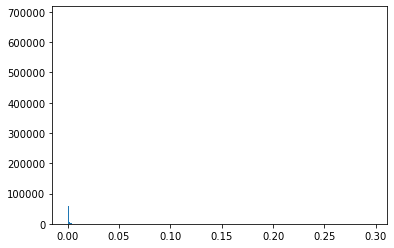

In [343]:
plt.hist(ratios, bins = 1000)

/home/s1992251/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


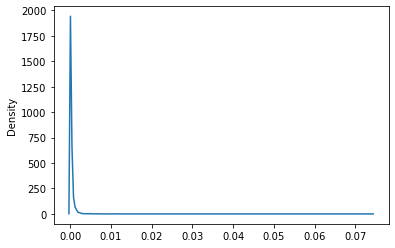

In [330]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(ratios[ratios>1e-10], hist = False, kde = True)

In [223]:
l = [1,2,3,4]

random.shuffle(l)

l

[3, 2, 4, 1]

In [219]:
np.mean(ratios)

0.00035713951586041317

In [218]:
np.std(ratios)

0.0009815902215337296

In [267]:
def rejection_sampler():
    count  = 0
    boo = True
    while(boo):
        count+=1
        pot_cells = display_draw(pots)
        games = []
        boo = False
        for i, game in enumerate(list_games):
            pot, cell = divmod(game[0], 3)
            pot1, cell1 = divmod(game[1], 3)
            celltot = access_cell(pot_cells, pot,cell)
            celltot1 = access_cell(pot_cells, pot1,cell1)
            cell_countries = [celltot[i][1] for i in range(3)]
            cell_countries1 = [celltot1[i][1] for i in range(3)]

            comb = list(zip(celltot1, cell_countries1))


            random.shuffle(comb)

            celltot1, cell_countries1 = zip(*comb)
            #print()

            if(any(elem1 == elem2 for elem1, elem2 in zip(cell_countries, cell_countries1))):
                #print("yes")
                boo = True
                break
            games.append(list(zip(celltot, celltot1)))
            
    return(count)
    #print(count)
        
        

In [268]:
rejection_sampler()

760

In [270]:
rejects = np.zeros(200)
for i in range(200):
    rejects[i] = rejection_sampler()
np.mean(rejects)

2579.36

In [570]:
G1 = nx.from_numpy_array(create_adj_mat(5))
nx.edge_connectivity(G1)

7

In [577]:
N = 1000
edge_connects = np.zeros(N)
for i in range(N):
    G1 = nx.from_numpy_array(create_adj_mat(5))
    edge_connects[i] = nx.edge_connectivity(G1)

In [578]:
edge_connects

array([7., 7., 7., 7., 7., 7., 8., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 8., 7., 7., 7., 7., 7., 7., 7., 7., 8., 8., 7., 7., 7.,
       7., 8., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       8., 7., 7., 7., 7., 7., 7., 7., 7., 8., 7., 7., 7., 7., 7., 8., 7.,
       7., 8., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 8., 7., 7., 7., 7., 7., 7., 7., 7., 8., 8., 7., 7., 7., 7., 7.,
       7., 7., 7., 8., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 8., 7., 7.,
       8., 7., 7., 7., 7., 7., 7., 8., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 8., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 8., 7., 7., 8., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 8., 7., 7., 7., 8., 8., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 8.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7.

In [609]:
N = 100
clique = list()
for i in range(N):
    G1 = nx.from_numpy_array(create_adj_mat(5))
    clique.append(len(nx.approximation.max_clique(G1)))

In [610]:
clique

[3,
 3,
 4,
 4,
 3,
 3,
 4,
 4,
 3,
 3,
 3,
 3,
 4,
 3,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 4,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 4,
 3,
 4,
 3,
 4,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 4,
 4,
 4,
 4,
 3,
 4,
 4,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 3,
 4,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 4,
 3,
 3,
 4,
 3,
 4,
 4,
 4,
 4,
 3,
 3,
 4]

In [78]:
arr = np.array([1,2,3,4,5,6,7,8,9])
np.random.shuffle(arr[2:])

In [98]:
arr

array([1, 2, 7, 5, 3, 9, 6, 4, 8])